# Lab 1 Report

## Table of Contents:

###   1. Imports and General Functions

###   2. Read in Data
    a. Separate Bias frames from Flat frames
    b. Master Bias
    c. Bias Subtract
    d. Exposure Time
    e. Image Show

###   3. Histograms

###   4. Mean and Standard Deviation
    a. Mean of 9 different exposure frames
    b. Standard deviation of 9 different exposure frames
    c. Plot of Mean vs. Standard Deviation
    d. Plot of Mean vs. Standard Deviation (log scale)

###   5. FLat Frame Division

###   6. Mean of the Mean and Standard Deviation of the Mean
    a. Mean of the Mean
    b. Standard Deviation of the Mean
    a. Plot of Number of Counts (ADU) vs. MOM & SDOM

###   7. Poisson Distribution

###   8. Mean and Standard Deviation of Poisson Fit Files

###   9. Gaussian Plots

###   10. Readnoise and Gain

###   11. Mean Variance and Mean Counts


# 1. Imports and General Functions

In [30]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import glob
import math
import ipywidgets as widgets

# Create a list of zeros
def zeros(n, dtype=int):
    return [dtype(0.0)] * n

# Compute the Mean value
def my_avg(x, dtype=float):
    tot = float(0)
    for i in x:
        tot += i

    m =  tot/len(x)
    return m

# Compute the Standard Deviation
def my_std(x, dtype=float):
    m = my_avg(x)
    tot = float(0)
    for i in x:
        tot += (i-m)**2

    return (tot/len(x))**0.5

# [EVAN WATSON]: reorganize the list of names of files to be in numerical order after glob
def ascend_str(ls, idxs):
    idx = 0
    idx_slice = slice(idxs[0], idxs[1])  # make slice for desired indices
    while idx < len(ls):
        for i, x in enumerate(ls):
            if i > idx and int(x[idx_slice]) < int(ls[idx][idx_slice]):  # check for lowest integer at given indices
                ls[i], ls[idx] = ls[idx], x

        idx += 1
    return None

# Get the exposure time of desired file
def get_exp(x):
    with fits.open(x) as hdu:
        hdr = hdu[0].header
    return hdr['EXPTIME']

# [EVAN WATSON]: Sets the negative values in a file array to zero for cleaner value control
def set_negatives_to_zero_nd(tensor):
    """
    sets negative values to 0 inplace for a rank n tensor
    """
    # check for rank 1
    ele = tensor[0]
    if isinstance(ele, np.ndarray):
        # not inside rank 1 yet so recursively loop with self call
        for sub in tensor:
            set_negatives_to_zero_nd(sub)
    else:
        # we are inside the rank 1 now
        for i, val in enumerate(tensor):
            if val < 0:                         # if less than zero
                tensor[i] = 0                   # set to zero
    return None

# [EVAN WATSON]: combines the legends of multiple axis plots. Used for Gaussian and Poisson Plots
def combine_legend(fig, **legend_kwargs):
    """
    combines legend elements of all axes in a fig
    :param fig: plt figure
    :param legend_kwargs: kwargs for legend
    :return: None, legend will be placed
    """
    axes = fig.get_axes()
    combined_handles = []
    combined_labels = []
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        combined_handles.extend(handles)
        combined_labels.extend(labels)
    axes[-1].legend(combined_handles, combined_labels, **legend_kwargs)

# 2. Read in Data

## 2a. Separate Bias and Flat Frames
glob in all of the file names and order them numerically, then separate the bias frames from the regular frames

In [31]:
frames = glob.glob('Lab1_data/d20[0-8][0-9].fits')
ascend_str(frames, (-7, -5))
bias_frames = frames[:11]
reg_frames = frames[11:]
bias_frames, reg_frames


(['Lab1_data/d2001.fits',
  'Lab1_data/d2002.fits',
  'Lab1_data/d2003.fits',
  'Lab1_data/d2004.fits',
  'Lab1_data/d2005.fits',
  'Lab1_data/d2006.fits',
  'Lab1_data/d2007.fits',
  'Lab1_data/d2008.fits',
  'Lab1_data/d2009.fits',
  'Lab1_data/d2010.fits',
  'Lab1_data/d2011.fits'],
 ['Lab1_data/d2043.fits',
  'Lab1_data/d2044.fits',
  'Lab1_data/d2045.fits',
  'Lab1_data/d2046.fits',
  'Lab1_data/d2047.fits',
  'Lab1_data/d2048.fits',
  'Lab1_data/d2049.fits',
  'Lab1_data/d2050.fits',
  'Lab1_data/d2051.fits',
  'Lab1_data/d2052.fits',
  'Lab1_data/d2053.fits',
  'Lab1_data/d2054.fits',
  'Lab1_data/d2055.fits',
  'Lab1_data/d2056.fits',
  'Lab1_data/d2057.fits',
  'Lab1_data/d2058.fits',
  'Lab1_data/d2059.fits',
  'Lab1_data/d2060.fits',
  'Lab1_data/d2061.fits',
  'Lab1_data/d2062.fits',
  'Lab1_data/d2063.fits',
  'Lab1_data/d2064.fits',
  'Lab1_data/d2065.fits',
  'Lab1_data/d2066.fits',
  'Lab1_data/d2067.fits',
  'Lab1_data/d2068.fits',
  'Lab1_data/d2069.fits',
  'Lab1_dat

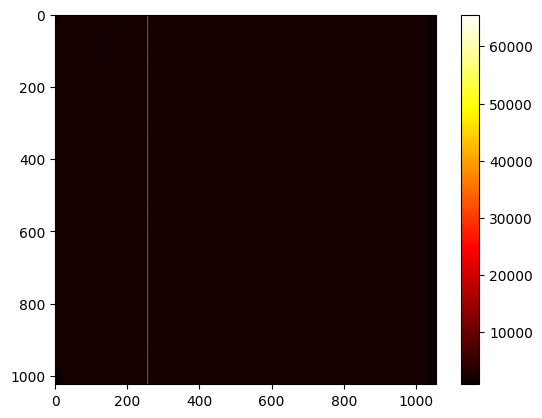

In [32]:
# Quick imshow frame test
test_frame = fits.getdata(reg_frames[0])
plt.imshow(test_frame, cmap='hot')
plt.colorbar()
plt.show()

In [33]:
# quick data display check
with fits.open(reg_frames[0]) as hdu:
    hdr = hdu[0].header
    display(hdr)

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 1056 / NUMBER OF COLUMNS                              
NAXIS2  =                 1024 / NUMBER OF ROWS                                 
CRVAL1U =                 2048 / COLUMN ORIGIN                                  
CRVAL2U =                 2048 / ROW ORIGIN                                     
CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           
OBSNUM  =                 2043 / OBSERVATION NUMBER                             
IDNUM   =                    3 / IMAGE ID                                       
UGEOM   =                    0 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

## 2b. Master Bias Frame
Average the bias frames to create the master bias and show its image

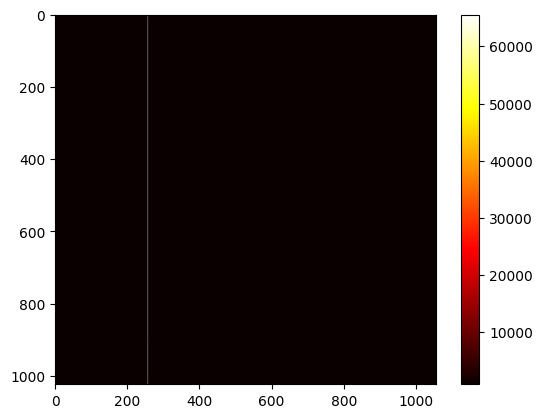

In [34]:
def bias(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr
    avg = my_avg(tot)
    return avg

master_bias = bias(bias_frames)
plt.imshow(master_bias, cmap='hot')
plt.colorbar()
plt.show()

## 2c. Bias Subtraction
Subtract the master bias from each of the regular frames and confirm their shape as well as setting the negatives in the files to zero for cleaner data output

In [35]:
def bias_sub(x):
    n = len(x)
    tot = zeros(n, dtype=float)

    for i, file in enumerate(x):
        arr = fits.getdata(file)
        tot[i] = arr - master_bias
    return tot

clean_data = bias_sub(reg_frames)
set_negatives_to_zero_nd(clean_data)
print(np.shape(clean_data), np.min(clean_data))

(43, 1024, 1056) 0.0


## 2d. Clean Data Image Show
Image show of our bias subtracted data, noticeably redder

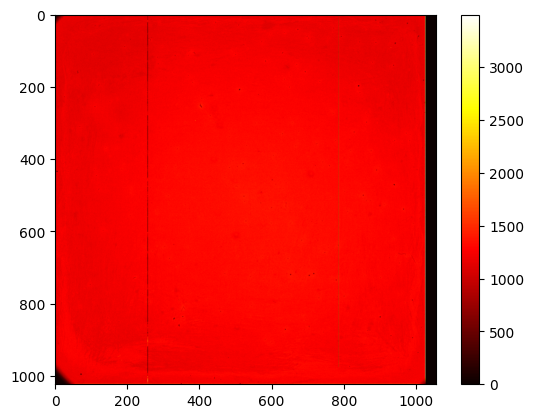

In [36]:
plt.imshow(clean_data[0], cmap='hot')
plt.colorbar()
plt.show()

## 2e. Exposure Frames
Loop through the regular files and pull out one file for every exposure time

In [37]:
def exp_frames(x):
    tot = []
    for i in range(0,len(x),5):
        tot.append(x[i])
    return tot

exp_frames = exp_frames(clean_data)


# 3. Histograms
Function for plotting histograms, then loop through our separated exposure frames and plot the 9 different Histograms with increasing exposure time

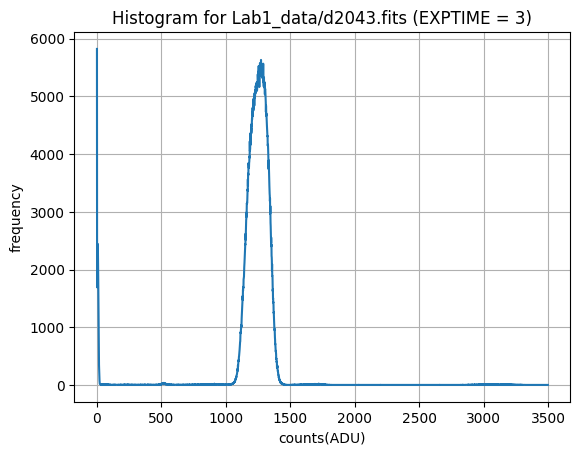

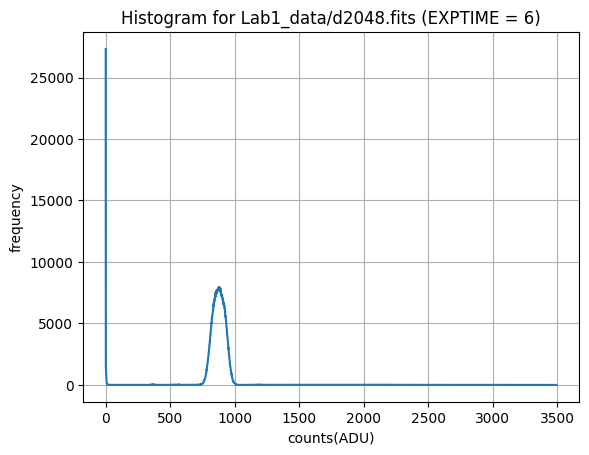

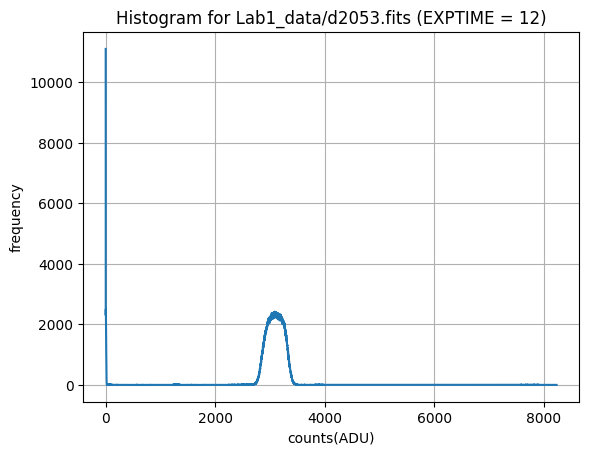

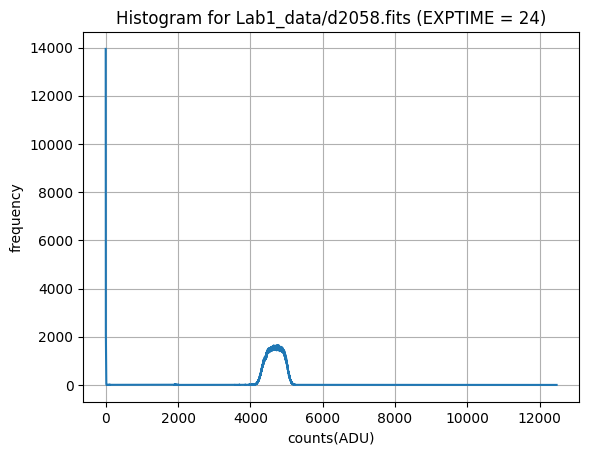

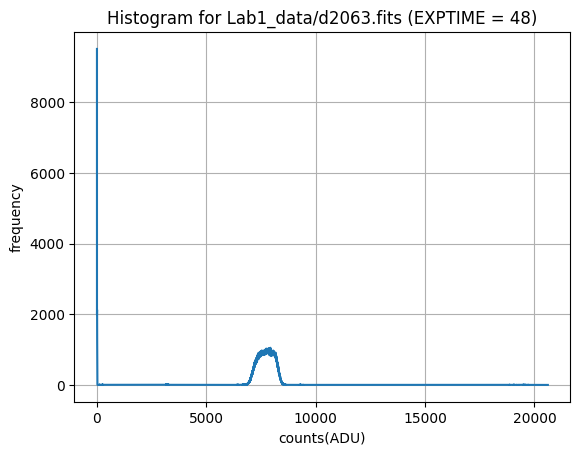

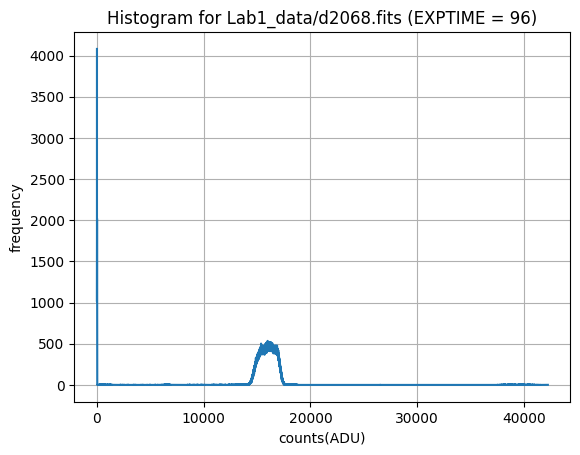

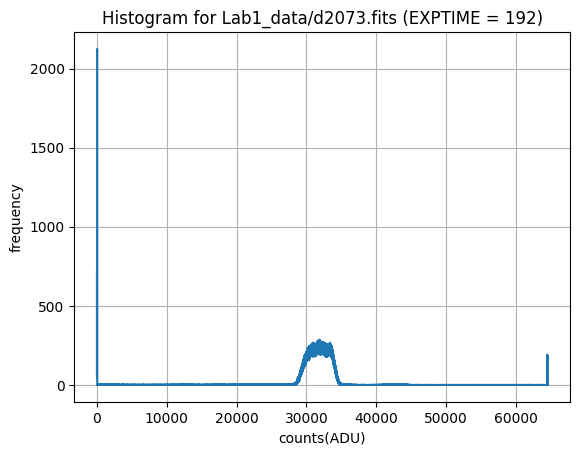

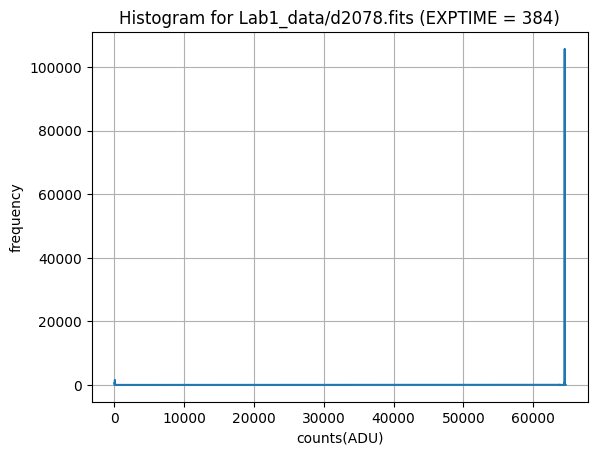

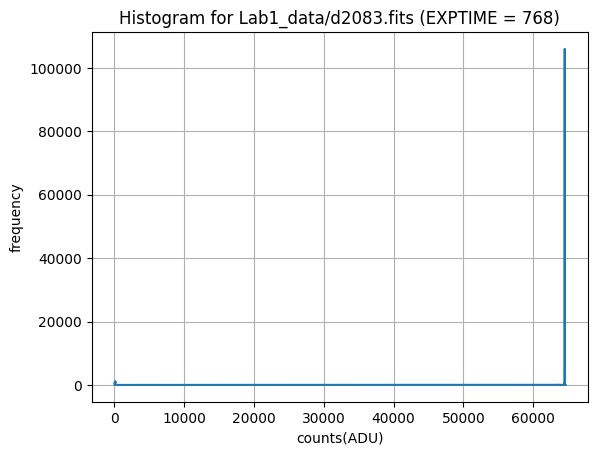

In [62]:
def histogram(file):

    farr = file.flatten()

    hmin = int(farr.min())
    hmax = int(farr.max())
    #hmax = int(farr.max())

    # initialize bins and empty count x[i]
    hr = np.arange(hmin, hmax + 1)
    hist = zeros(hmax - hmin + 1, dtype=int)

    # count each value in bins
    for value in farr:
        if hmin <= value <= hmax:
            hist[int(value - hmin)] += 1

    return hr, hist




for i, data in enumerate(exp_frames):

    idx = int(i*5)
    exp_time = get_exp(reg_frames[idx])
    hr, hist = histogram(data)
    plt.plot(hr, hist)
    plt.xlabel('counts(ADU)')
    plt.ylabel('frequency')
    plt.title(f'Histogram for {reg_frames[idx]} (EXPTIME = {exp_time})')
    plt.grid()
    plt.show()


# 4. Mean and Standard Deviation
## 4a. Mean and Standard Deviation of each exposure time
Loop through the different exposure time files and calculate thier mean and standard deviation

In [63]:
n = len(exp_frames)
means = zeros(n)
stds = zeros(n)

for i,data in enumerate(exp_frames):
    idx = int(i*5)
    fdata = data.flatten()
    file = reg_frames[idx]
    exp_time = get_exp(reg_frames[idx])
    means = my_avg(fdata)
    stds = my_std(fdata)
    print(f'File: {file} EXP:{exp_time}')
    print(f'Mean: {means}')
    print(f'Standard Deviation: {stds}')
    print('------------------------')


File: Lab1_data/d2043.fits EXP:3
Mean: 1213.54258395951
Standard Deviation: 243.63819202177527
------------------------
File: Lab1_data/d2048.fits EXP:6
Mean: 850.7603714367333
Standard Deviation: 172.07854891273178
------------------------
File: Lab1_data/d2053.fits EXP:12
Mean: 3000.4999873053794
Standard Deviation: 600.8876795432038
------------------------
File: Lab1_data/d2058.fits EXP:24
Mean: 4538.5804702295545
Standard Deviation: 908.6361523537043
------------------------
File: Lab1_data/d2063.fits EXP:48
Mean: 7488.739279418763
Standard Deviation: 1496.6312775139857
------------------------
File: Lab1_data/d2068.fits EXP:96
Mean: 15494.145201122927
Standard Deviation: 3094.7707389025027
------------------------
File: Lab1_data/d2073.fits EXP:192
Mean: 30795.93051147559
Standard Deviation: 5993.12972541988
------------------------
File: Lab1_data/d2078.fits EXP:384
Mean: 62366.44977302471
Standard Deviation: 11413.106452399581
------------------------
File: Lab1_data/d2083.fits

## 4b. Mean vs. Standard Deviation Plot

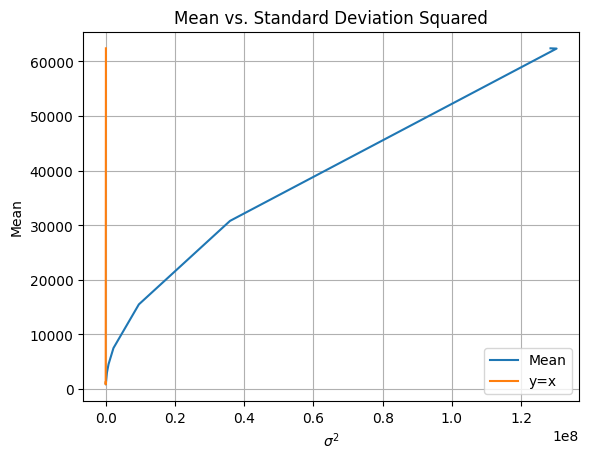

In [40]:
avg = zeros(len(exp_frames), dtype=float)
dev = zeros(len(exp_frames), dtype=float)


for i,data in enumerate(exp_frames):
    avg[i] = my_avg(data.flatten())
    dev[i] = my_std(data.flatten())

devsqr = list(map(lambda x: x**2, dev))

fig, ax = plt.subplots()

ax.plot(devsqr,avg, label='Mean')
ax.plot(avg,avg, label='y=x')
plt.xlabel(r'$\sigma^2$')
plt.ylabel('Mean')
plt.title('Mean vs. Standard Deviation Squared')
plt.grid()
plt.legend()
plt.show()

## 4e. Mean vs. Standard Deviation Plot (log scale)

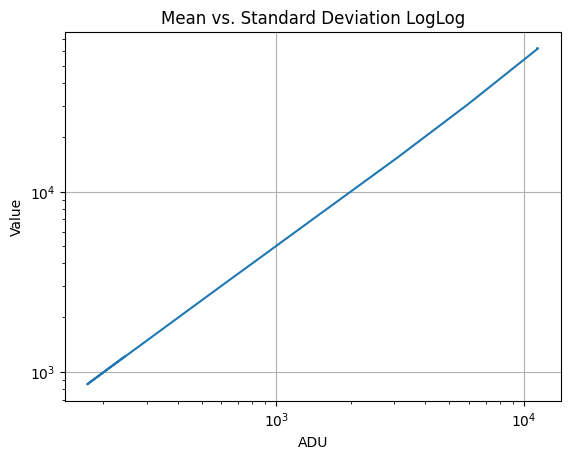

In [41]:
plt.loglog(dev,avg)
plt.xlabel('ADU')
plt.ylabel('Value')
plt.title('Mean vs. Standard Deviation LogLog')
plt.grid()
plt.show()

# 5. Flat Frame Division

In [53]:
def ffdiv(x,file):
    exp = get_exp(file)
    return x/exp


reduced_flats = zeros(len(clean_data), dtype=float)
for i,x in enumerate(clean_data):
    reduced_flats[i] = ffdiv(x,reg_frames[i])
np.shape(reduced_flats)
type(reduced_flats)

list

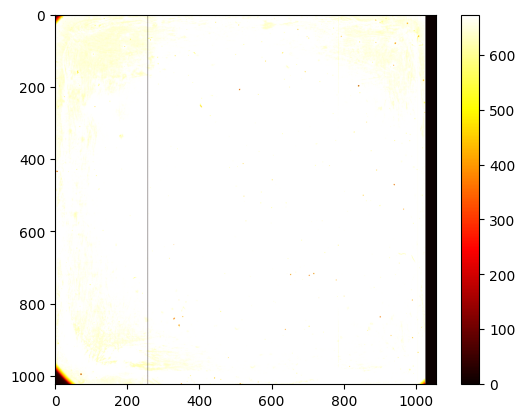

In [43]:
plt.imshow(reduced_flats[-4], cmap='hot')
plt.colorbar()
plt.show()

# 6. Mean of the Mean and Standard Deviation of the Mean

In [54]:
n = len(reduced_flats)
means = []
MOMs = zeros(n, dtype=float)
SDOMs = zeros(n, dtype=float)

for i,x in enumerate(reduced_flats):
    fx = x.flatten()
    means.append(my_avg(fx))
    MOM = my_avg(means)
    SDOM = my_std(means)
    MOMs[i] = MOM
    SDOMs[i] = SDOM


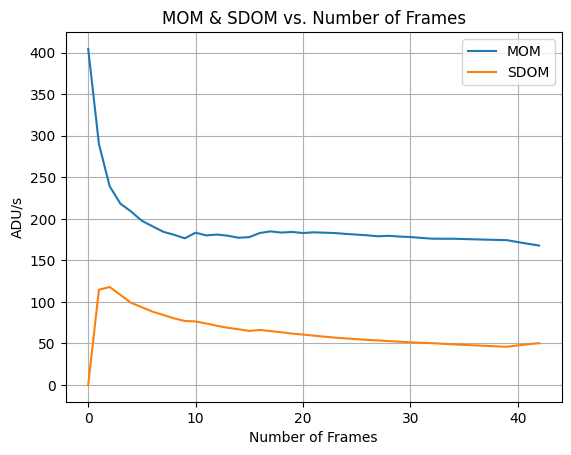

In [56]:
num_frames = np.arange(0,len(clean_data))

fig, ax = plt.subplots()
ax.plot(num_frames,MOMs, label='MOM')
ax.plot(num_frames,SDOMs, label='SDOM')
plt.xlabel('Number of Frames')
plt.ylabel('ADU/s')
plt.title('MOM & SDOM vs. Number of Frames')
plt.grid()
ax.legend()
plt.show()

# 7. Poisson Distribution

## 7a. Poisson Functions

In [46]:
def poisson_log(x, mu):
    """
    Logarithmic approximation of Poisson distribution to avoid overflow error
    :param x: float, x value, must be positive
    :param mu: float, mean of the distribution
    :return: approximate value of the Poisson distribution
    """
    if x==0:
        log = -mu
    else:
        log = x * (math.log(mu) - math.log(x)) + x - mu
    return math.exp(log)

def get_poisson(data, xrange=None):
    fdata = data.flatten()
    mu = my_avg(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)

    p_values = [poisson_log(x, mu) for x in x_values]

    return x_values, p_values


## 7b. Poisson vs. Histogram Plot

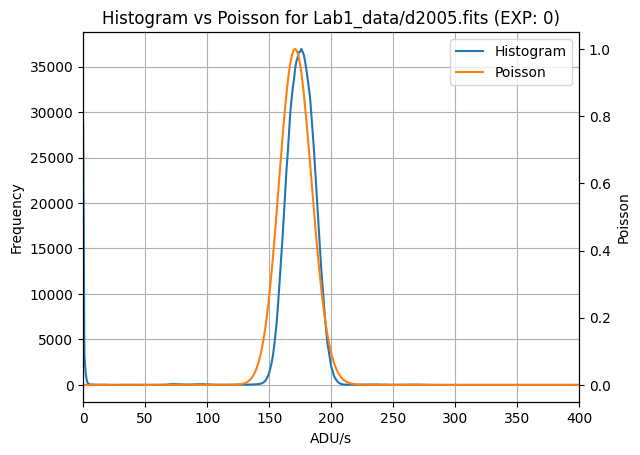

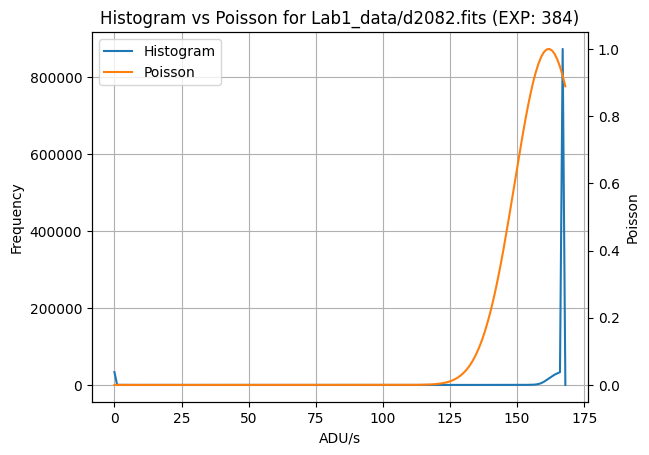

In [58]:
chosen_frames = (reduced_flats[4], reduced_flats[-4])
for i, data in enumerate(chosen_frames):
    idx = int(-8*i + 4)
    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)

    x, p = get_poisson(data)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(hr, hist, label='Histogram', color='tab:blue')
    ax2.plot(x, p, label='Poisson', color='tab:orange')

    combine_legend(fig)

    if i==0:
        plt.xlim(0, 400)

    ax1.grid()
    ax1.set_xlabel('ADU/s')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Poisson')
    ax.legend()
    plt.title(f'Histogram vs Poisson for {frames[idx]} (EXP: {exp_time})')
    plt.show()


# 8. Mean and Standard Deviation of Poisson Files

In [59]:
for i,data in enumerate(chosen_frames):
    fdata = data.flatten()
    idx = int(-8*i + 4)
    name = frames[idx]
    exp_time = get_exp(name)
    mean = my_avg(fdata)
    std = my_std(fdata)
    print(f'Frame: {name}, EXP: {exp_time}')
    print(f'Mean: {mean}')
    print(f'STD: {std}')
    print('-------------------------')


Frame: Lab1_data/d2005.fits, EXP: 0
Mean: 170.9042623220421
STD: 34.97446079221624
-------------------------
Frame: Lab1_data/d2082.fits, EXP: 384
Mean: 161.77758872476394
STD: 29.699390118887706
-------------------------


# 9. Gaussian Function

## 9a. Gaussian Functions

In [60]:
def gaussian(x, mu, sigma):
    coeff = 1/(sigma * (2*math.pi)**0.5)
    expo = math.exp(-(1/2)*((x - mu)/sigma)**2)
    return coeff * expo

def get_gaussian(data, xrange=None):
    fdata = data.flatten()
    mu = my_avg(fdata)
    sigma = my_std(fdata)
    if xrange is None:
        x_min = int(fdata.min())
        x_max = int(fdata.max())
    else:
        x_min, x_max = xrange

    x_values = np.arange(x_min, x_max + 1)
    g_values = [gaussian(x, mu, sigma) for x in x_values]

    return x_values, g_values

## 9b. Gaussian Plot

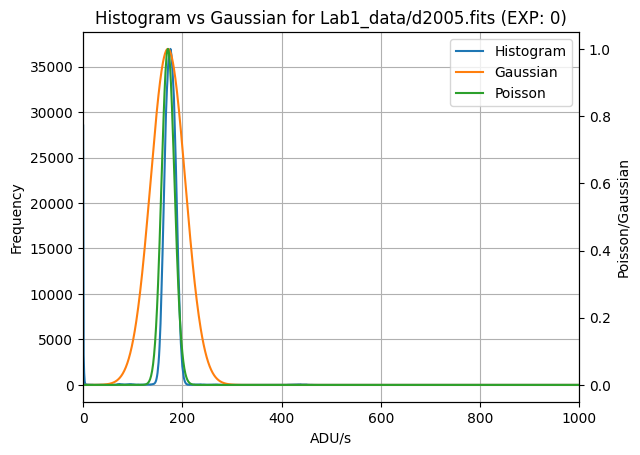

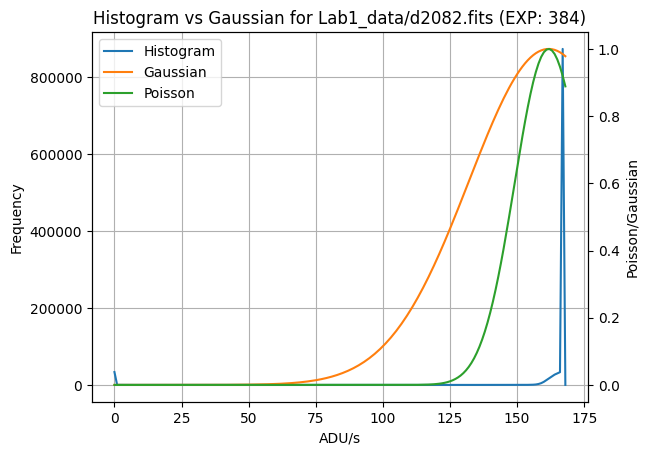

In [61]:
for i, data in enumerate(chosen_frames):
    idx = int(-8*i + 4)

    exp_time = get_exp(frames[idx])
    hr, hist = histogram(data)

    x1, g = get_gaussian(data)
    x2, p = get_poisson(data)
    scale_factor = max(g)

    g = [gv/scale_factor for gv in g]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(hr, hist, label='Histogram', color='tab:blue')

    ax2.plot(x1, g, label='Gaussian', color='tab:orange')
    ax2.plot(x2, p, label='Poisson', color='tab:green')

    ax1.set_xlabel('ADU/s')
    ax1.set_ylabel('Frequency')
    ax2.set_ylabel('Poisson/Gaussian')

    combine_legend(fig)

    if i==0:
        ax1.set_xlim(0, 1000)

    ax1.grid()
    plt.title(f'Histogram vs Gaussian for {frames[idx]} (EXP: {exp_time})')
    plt.show()

# 10. Readnoise and Gain

## 10a. Pixel Selection

In [17]:
frame = clean_data[-4]

def display_crop(row, col, window_size):

    crop = frame[row:row+window_size, col:col+window_size]
    plt.imshow(crop, cmap='hot')
    plt.title(f'({row}, {col})')
    plt.colorbar()
    plt.show()

win_size = 75
step_size = 5

row_slider = widgets.IntSlider(min=0, max=frame.shape[0]-win_size-1, step=step_size, value=375)
col_slider = widgets.IntSlider(min=0, max=frame.shape[0]-win_size-1, step=step_size, value=375)
win_slider = widgets.IntSlider(min=5, max=200, step=step_size, value=win_size)

widgets.interact(display_crop, row=row_slider, col=col_slider, window_size=win_slider)

interactive(children=(IntSlider(value=375, description='row', max=948, step=5), IntSlider(value=375, descripti…

<function __main__.display_crop(row, col, window_size)>

## 10b. Clean Pixel Slice

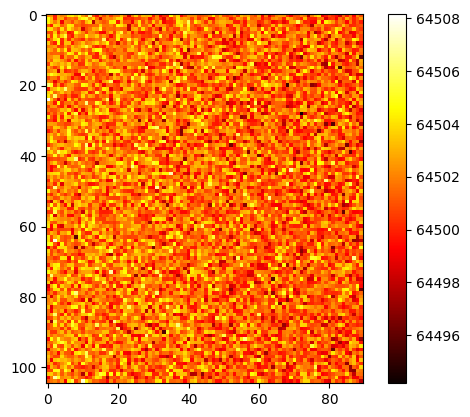

In [18]:
clean_pix_slice = (slice(385,490), slice(390,480))
clean_pixels = clean_data[-4][clean_pix_slice]
plt.imshow(clean_pixels, cmap='hot')
plt.colorbar()
plt.show()

# 11. Mean Variance and Mean Counts

In [67]:

master_exp = zeros(9, dtype=float)

n_exps = zeros(9, dtype=int)

possible_exposures = []
for i,data in enumerate(clean_data):
    exp_time = get_exp(frames[i])
    if exp_time not in possible_exposures:
        possible_exposures.append(exp_time)


    exp_idx = possible_exposures.index(exp_time)
    master_exp[exp_idx] += data
    n_exps[exp_idx] += 1

for i,mdata in enumerate(master_exp):
    mdata /= n_exps[i]

print(np.shape(master_exp))

(9, 1024, 1056)


In [68]:
def mean_variance(flat0, flat1):



    diff = (flat1-flat0).flatten()
    var = [d**2 for d in diff]
    return my_avg(var)

In [69]:
mean_counts = zeros(len(clean_data), dtype=float)
mean_var = zeros(len(clean_data), dtype=float)
for i,data in enumerate(clean_data):
    exp_time = get_exp(frames[i])
    exp_idx = possible_exposures.index(exp_time)
    master = master_exp[exp_idx]
    cropped_data = data[clean_pix_slice]
    cropped_master = master[clean_pix_slice]
    mean_counts[i] = my_avg(cropped_data.flatten())
    mean_var[i] = mean_variance(cropped_master, cropped_data)

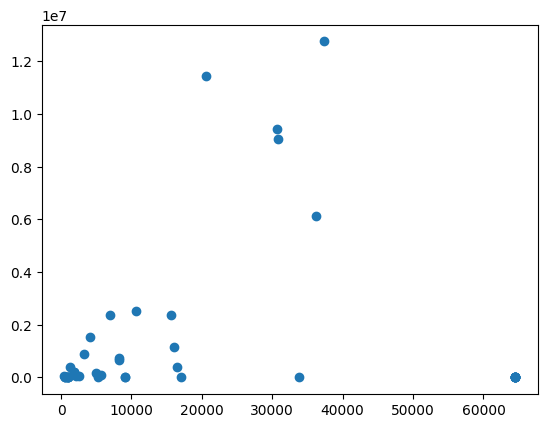

In [97]:
plt.scatter(mean_counts, mean_var)
plt.show()